In [2]:
import numpy as np
words = np.load(f"/proj/inductive-bias.shadow/abakalov.data/words_fmri.npy")

In [3]:
from nltk.tokenize import sent_tokenize
# import nltk
# nltk.download("punkt")
text = " ".join(words)
text_tokenized = [sent.split() for sent in sent_tokenize(text)]
import stanza

nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,depparse,constituency', use_gpu=False, tokenize_pretokenized=True) # Build the pipeline, specify part-of-speech processor's batch size
doc = nlp(text_tokenized) # Run the pipeline on the input text

/local/abakalov/anaconda3/envs/alignment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-02 16:15:36 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-03-02 16:15:36 INFO: Downloaded file to /home/CE/abakalov/stanza_resources/resources.json
2024-03-02 16:15:37 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| mwt          | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |

2024-03-02 16:15:37 INFO: Us

In [177]:
def get_smallest_phrase_constituents(parsed_sent):
    phrase_constituents = ["ADJP", "ADVP", "CONJP", "FRAG", "INTJ", "LST", "NAC", "NP", "NX", "PP", \
                           "PRN", "PRT", "QP", "RRC", "UCP", "VP", "WHADJP", "WHAVP", "WHNP", "WHPP", "X"]
    def find_smallest_phrase_constituents(tree, last_constituent=None):
        if len(tree.children) == 0:
            return [last_constituent]
        to_return = []
        if tree.label in phrase_constituents:
            for child in tree.children:
                to_return = to_return + find_smallest_phrase_constituents(child, last_constituent=tree.label)
        else:
            for child in tree.children:
                to_return = to_return + find_smallest_phrase_constituents(child, last_constituent=last_constituent)
        return to_return
    
    smallest_constituents = find_smallest_phrase_constituents(parsed_sent.constituency, last_constituent=None)
    assert len(smallest_constituents) == len(parsed_sent.words)
    return smallest_constituents

def _get_feat(word, feat):
    if word is None:
        return None
    if word.feats is None:
        return "UNDEF"
    feats = {feat.split("=")[0]: feat.split("=")[1] for feat in word.feats.split("|")}
    if feat not in feats:
        return "UNDEF"
    return feats[feat]

def get_word_depth(parsed_sent):
    tree = defaultdict(list)
    word_depth = [0 for i in range(len(parsed_sent.words) + 1)]
    for word in parsed_sent.words:
        tree[word.head].append(word.id)
    word_depth[tree[0][0]] = 0
    def count_words_depth(root_id):
        for word in tree[root_id]:
            word_depth[word] = word_depth[root_id] + 1
            count_words_depth(word)
    count_words_depth(tree[0][0])
    return word_depth

def get_subj_number(parsed_sent, word_depth):
    potential_subj = []
    for word in parsed_sent.words:
        if word.deprel == "nsubj":
            potential_subj.append(word)
    if len(potential_subj) == 0:
        return None
    subj = sorted(potential_subj, key=lambda subj: word_depth[subj.id])[0]
    return _get_feat(subj, "Number")

def get_obj_number(parsed_sent, word_depth):
    potential_obj = []
    for word in parsed_sent.words:
        if word.deprel == "obj":
            potential_obj.append(word)
    if len(potential_obj) == 0:
        return None
    obj = sorted(potential_obj, key=lambda obj: word_depth[obj.id])[0]
    return _get_feat(obj, "Number")

def get_verb_tense(parsed_sent, word_depth):
    potential_verbs = []
    for word in parsed_sent.words:
        feat = _get_feat(word, "Tense")
        if feat is not None and feat != "UNDEF":
            potential_verbs.append(word)
    if len(potential_verbs) == 0:
        return None
    verb = sorted(potential_verbs, key=lambda vb: word_depth[vb.id])[0]
    return _get_feat(verb, "Tense")

from collections import defaultdict
def get_features(parsed_sent):
    smallest_constituents = get_smallest_phrase_constituents(parsed_sent)
    
    word_depth = get_word_depth(parsed_sent)
    subj_num = get_subj_number(parsed_sent, word_depth)
    obj_num = get_obj_number(parsed_sent, word_depth)
    vb_tense = get_verb_tense(parsed_sent, word_depth)

    return {
        "sentence_length": len(parsed_sent.words),
        "tree_depth": max(word_depth),
        "top_constituents": tuple([child.label for child in parsed_sent.constituency.children[0].children]),
        "tense": vb_tense,
        "subject_number": subj_num,
        "object_number": obj_num,

        "pos_tags": [word.upos for word in parsed_sent.words],
        "deprel": [word.deprel for word in parsed_sent.words],
        "smallest_constituents": smallest_constituents,
        "word_depth": word_depth
    }

In [178]:
features = []
for sent in doc.sentences:
    features.append(get_features(sent))

In [197]:
from collections import defaultdict
features_by_feature = defaultdict(list)
for feture_by_sent in features:
    for feature, value in feture_by_sent.items():
        features_by_feature[feature].append(value)

In [198]:
from collections import Counter
def find_best_bins(sorted_counter_array, num_bins):
    total_number_of_data = sum([cnt for val, cnt in sorted_counter_array])
    data_in_bins = [0] * num_bins
    bins_start = [0] * num_bins
    bins_end = [0] * num_bins
    cur_bin = 0
    for i, (val, cnt) in enumerate(sorted_counter_array):
        if data_in_bins[cur_bin] == 0:
            bins_start[cur_bin] = val
        if data_in_bins[cur_bin] + cnt < total_number_of_data // num_bins or cur_bin == num_bins - 1:
            data_in_bins[cur_bin] += cnt
        else:
            bins_end[cur_bin] = val
            data_in_bins[cur_bin] += cnt
            cur_bin += 1

    bins_end[num_bins - 1] = sorted_counter_array[-1][0]
    bins_description = [(s, e) for s, e in zip(bins_start, bins_end)]
    print(f"total data points: {total_number_of_data}, in bin ideal {total_number_of_data // num_bins} in bin real {data_in_bins}")
    return [(descr, val) for descr, val in zip(bins_description, data_in_bins)]

In [199]:
def top_n_and_other(sorted_counter_array, n):
    total_number_of_data = sum([cnt for val, cnt in sorted_counter_array])
    to_return = sorted_counter_array[:n - 1] + [("other", total_number_of_data - sum([cnt for val, cnt in sorted_counter_array[:n - 1]]))]
    print(f"total data points: {total_number_of_data}, in bins {[cnt for val, cnt in to_return]}")
    return to_return

In [200]:
def undef_and_none_together(sorted_counter_array):
    undef_total = 0
    result_counter_array = []
    for val, cnt in sorted_counter_array:
        if val is None or val == "UNDEF":
            undef_total += cnt
        else:
            result_counter_array.append((val, cnt))
    result_counter_array.append(("UNDEF", undef_total))
    return result_counter_array

In [201]:
from collections import Counter
sent_level_features = ["sentence_length", "tree_depth", "top_constituents", "tense", "subject_number", "object_number"]
features_by_feature_dist = {
    k: Counter(v).most_common() for k, v in features_by_feature.items() if k in sent_level_features
}

features_by_feature_dist["sentence_length"] = find_best_bins(sorted(Counter(features_by_feature["sentence_length"]).most_common()), 3)
features_by_feature_dist["tree_depth"] = find_best_bins(sorted(Counter(features_by_feature["tree_depth"]).most_common()), 2)
features_by_feature_dist["top_constituents"] = top_n_and_other(list(Counter(features_by_feature["top_constituents"]).most_common()), 2)
features_by_feature_dist["subject_number"] = undef_and_none_together(list(Counter(features_by_feature["subject_number"]).most_common()))
features_by_feature_dist["object_number"] = undef_and_none_together(list(Counter(features_by_feature["object_number"]).most_common()))

total data points: 417, in bin ideal 139 in bin real [156, 147, 114]
total data points: 417, in bin ideal 208 in bin real [278, 139]
total data points: 417, in bins [89, 328]


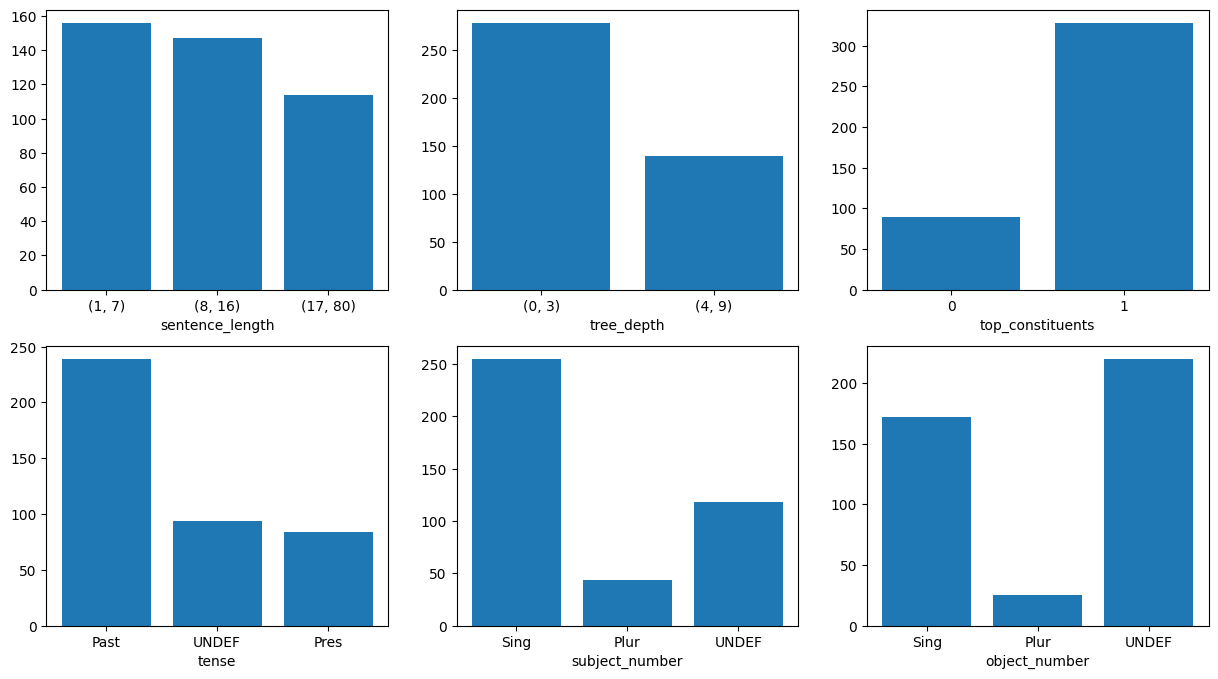

In [202]:
import matplotlib.pyplot as plt
y_axis_plots = 2
x_axis_plots = 3
fig, axs = plt.subplots(y_axis_plots, x_axis_plots)
fig.set_size_inches((15, 8))
for i, feature in enumerate(sent_level_features):
    xs, ys = zip(*features_by_feature_dist[feature])
    axs[i // x_axis_plots][i % x_axis_plots].bar(list(range(len(xs))), ys)
    if feature == "top_constituents":
        axs[i // x_axis_plots][i % x_axis_plots].set_xticks(list(range(len(xs))), list(range(len(xs))))
    else:
        axs[i // x_axis_plots][i % x_axis_plots].set_xticks(list(range(len(xs))), [x if x is not None else "UNDEF" for x in xs])
    axs[i // x_axis_plots][i % x_axis_plots].set_xlabel(feature)
plt.show()